The non-linear models give generally better result and need less hypothisis (normality...). Let's do a comparaison. We'll use GradientBosstingRegressor.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import plotly.express as px
import seaborn as sns

# Load dataset
df = pd.read_csv('train.csv')  # Replace with your actual file path


# Select only object or category columns
cat_cols = df.select_dtypes(include=["object", "category"]).columns

# Fill NaN values in only those columns
df[cat_cols] = df[cat_cols].fillna("Missing")

## 1.1 convert types

In [2]:
df[['MSSubClass', 'MoSold', 'YearBuilt', 'YearRemodAdd', 'YrSold']] = df[['MSSubClass', 'MoSold', 'YearBuilt', 'YearRemodAdd', 'YrSold']].astype('object')

### Missing values

Unlike the linear model:

Keeping features with more than 30% missing values can still improve the model score if those features:

1. Have Strong Predictive Power
Even if many values are missing, the non-missing values might strongly correlate with house prices. For example:

A rare feature like "Luxury Finish Quality" might be present in only 40% of houses but highly predictive of high prices.

2. Missingness Is Informative
The fact that a value is missing can itself be predictive. For instance:

"Pool Size" missing might imply no pool → possibly lower price.

So, missing = meaningful, not just a problem.

3. Effective Imputation
If you handle missing values well (e.g., with mean/median, KNN, or even a separate "missing" category), the feature can still contribute positively without hurting the model.

4. Regularized Models Can Handle Noise
Algorithms like XGBoost, and Random Forest can handle missing values internally or tolerate noisy features due to their robustness.

🔑 In Short:
Dropping features just based on missingness may cause you to lose valuable information. If the signal outweighs the noise, even sparse features can boost prediction accuracy.

## 1.2 Imputation with 0

Imputing missing values with 0 instead of the mean can be better in specific machine learning contexts—but not universally. why imputing with 0 might be better:

✅ When Imputing with 0 Is Better:
1. Sparsity matters (e.g., one-hot encoded data, text features, TF-IDF)
Many ML datasets (especially from NLP or recommender systems) are sparse.

Imputing with 0 preserves sparsity, which:

Keeps the memory and computation efficient.

Makes sense semantically: 0 can represent "absence" (e.g., no word, no interaction).

2. 0 has a semantic meaning
In many domains, 0 has real-world meaning.

Example: Missing income → impute 0 to mean no income.

Example: Sensor failure → 0 may mean sensor off.

3. Avoids data leakage
Imputing with the mean uses information from the whole column.

If done before train-test split, it leaks future data into training.

Imputing with 0 is constant and does not leak information.

4. Tree-based models (like XGBoost) handle 0 well
These models can split on whether a value is 0 or not, giving them the power to learn missingness patterns.

They often perform better when missingness is made explicit (e.g., via 0 imputation or adding a missingness indicator).

❌ When Mean Imputation Might Be Better:
When missing values are random and data is normally distributed.

When 0 is not a valid value (e.g., age, height—0 makes no sense).

**When you're using linear models or neural nets that expect normalized input (0 may skew the distribution).**

In [3]:
df = df.fillna(0)

C:\Users\berra\AppData\Local\Temp\ipykernel_2104\3475559988.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)


## 1.3 create variables (for interpretation)

In [4]:
df_dropped = df.copy()

#'YearBuilt', 'YearRemodAdd, 'MoSold', 'YrSold' convert to quantitative
# List of columns to convert
columns_to_convert = ['YearBuilt', 'YearRemodAdd', 'MoSold', 'YrSold']

# Convert each to integer safely
for col in columns_to_convert:
    df_dropped.loc[:, col] = df_dropped[col].astype(int)

# Set reference year
reference_year = df_dropped['YrSold'].max()

# Create quantitative features safely
df_dropped.loc[:, 'HouseAge'] = reference_year - df_dropped['YearBuilt']
df_dropped.loc[:, 'YearsSinceRemod'] = reference_year -df_dropped['YearRemodAdd']

df_dropped = df_dropped.drop([
    'YearBuilt', 'YearRemodAdd', 'YrSold', 'MoSold'
], axis=1) 

# Convert object columns to numeric, forcing errors to NaN
cols_to_convert = ['HouseAge', 'YearsSinceRemod']
df_dropped[cols_to_convert] = df_dropped[cols_to_convert].apply(pd.to_numeric, errors='coerce')

### Skewness

Unlike linear models: no need correct skewness

Why Do We Log Transform Skewed Features?
The main reasons are:

To reduce the impact of extreme values (outliers).

To make distributions more normal, which helps linear models.

To improve symmetry and stabilize variance.

BUT: these assumptions are especially important for linear models, not necessarily for tree-based models.

🌲 Tree-Based Models (like Gradient Boosting) Don’t Need Normality
Decision trees (and boosting) do not assume normality or linearity.

They work by splitting data at thresholds (e.g., “is x < 3.7?”), not by computing coefficients like a regression.

Skewness doesn’t confuse them the same way it would a linear model.

In fact, applying log to features can flatten useful variation and reduce predictive power.

💡 So Why Might Removing Log Improve Performance?
Log transform compresses data → reduces the range, which could make it harder for trees to separate observations cleanly.

If your target variable (or features) has natural nonlinear relationships, log might distort them.

Gradient Boosting benefits from contrast and variability — log might smooth out informative spikes or patterns.

If your target is not log-transformed, then transforming features may cause distribution mismatch.

✅ When Should You Use Log?
If you’re using linear models (like linear regression, Lasso, Ridge).

If you’re predicting the log of the target variable (e.g., np.log(SalePrice)), then applying log to skewed features can make sense to preserve linearity.

If a skewed feature is heavily dominated by outliers.

📌 Best Practice for Tree Models
For models like Gradient Boosting, Random Forests, XGBoost, etc.:

Try training without log-transforming numeric features.

Use feature importance or SHAP to check if raw vs. transformed features perform better.

You can also try quantile binning or target encoding as alternatives to log.



## 1.4 cap outliers

In [5]:
# cap outliers
#outliers cap

num_features = [col for col in df_dropped.select_dtypes(include='number') if col != 'Id']
 
# Store the limits for each column
caps = {}

for col in num_features:
    q_low = df_dropped[col].quantile(0.01)
    q_high = df_dropped[col].quantile(0.99)
    
    # Save the thresholds
    caps[col] = (q_low, q_high)
    
    # Apply clipping
    df_dropped[col] = df_dropped[col].clip(lower=q_low, upper=q_high)



### Rare categories

Unlike the Linear model:

The presence of rare categories (<30 obs) in a column is generally okay for gradient boosting (like XGBoost...), especially compared to traditional models like linear regression or logistic regression. Here’s why:

✅ 1. Gradient Boosting Handles Categorical Splits Based on Target
Gradient boosting builds decision trees, which:

Split the data based on features that improve performance (reduce loss).

When a categorical variable is present, some implementations (like CatBoost and LightGBM) can natively handle categorical features.

If a rare category is not useful, the model simply won’t split on it.

Example:
If the rare category doesn’t provide a meaningful reduction in loss, gradient boosting ignores it during splitting.

✅ 2. Decision Trees Are Not Sensitive to Frequency
Unlike linear models:

Trees do not assume a linear relationship or rely on global statistics (like coefficients).

Even if a category appears rarely, if it helps to separate the target variable, the model can use it in a split.

✅ 3. Built-in Regularization Helps Avoid Overfitting to Rare Categories
Gradient boosting models have built-in mechanisms like:

Minimum samples per leaf/node

Maximum tree depth

Subsampling

Learning rate

These parameters help control overfitting, so even if a rare category accidentally looks predictive, the model won't over-rely on it.

⚠️ But Caution: Rare Categories Can Still Cause Overfitting in Some Cases
While they are usually handled well:

If your dataset is very small or noisy, rare categories might lead to overfitting, especially if they correlate with outliers.

It’s still good practice to:

Combine truly rare categories into an "Other" bucket (optional).

Ensure cross-validation is used to monitor overfitting.

## RandomizedSearchCV

In [32]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

X = df_dropped.drop(['Id','SalePrice'],axis=1)
y = df_dropped.SalePrice


# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]


# Preprocessing for categorical data
#categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'  # <-- this keeps the numerical columns
)

import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np



# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

# 3. Initialize the model
pipeline_GBR = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=1))
])

# 4. Define parameter grid for Random Search
param_grid = {
    'model__n_estimators': [100, 500,  1000, 1500],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.4, 0.6, 0.8],
    'model__loss': ['squared_error', 'absolute_error', 'huber']
}


# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline_GBR,
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=1,
    n_jobs=-1
)

# 6. Fit to training data
random_search.fit(X_train, y_train)

# 7. Evaluate best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [33]:
from pprint import pprint
pprint(best_model.named_steps['model'].get_params())

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.05,
 'loss': 'absolute_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1500,
 'n_iter_no_change': None,
 'random_state': 1,
 'subsample': 0.6,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


## GridSearchCV

In [34]:
from sklearn.model_selection import GridSearchCV

# Refined grid around the best values
param_grid = {
    'model__n_estimators': [1400, 1500, 1600],
    'model__learning_rate': [0.04, 0.05, 0.06],
    'model__subsample': [0.5, 0.6, 0.7],
    'model__loss': ['absolute_error']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline_GBR,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Fit to training data
grid_search.fit(X_train, y_train)

# Evaluate best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Best Parameters from Grid Search:")
print(grid_search.best_params_)
print(f"Test RMSE: {rmse:.2f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters from Grid Search:
{'model__learning_rate': 0.04, 'model__loss': 'absolute_error', 'model__n_estimators': 1600, 'model__subsample': 0.7}
Test RMSE: 20388.11


## 1.5 Selected Model

In [35]:
model_GBR =  GradientBoostingRegressor(n_estimators=1600, loss='absolute_error', subsample = 0.7, learning_rate = 0.04,random_state=1)
GBR_Pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', model_GBR)])
GBR_Pipeline.fit(X_train, y_train)

C:\Users\berra\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['MSZoning', 'Street',
                                                   'Alley', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LotConfig', 'LandSlope',
                                                   'Neighborhood', 'Condition1',
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle',
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', ...])])),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.04,
                                           loss='absolute_error',
                                           n_estimators=1600, random_state=1,
                                           subsample=0.7))])

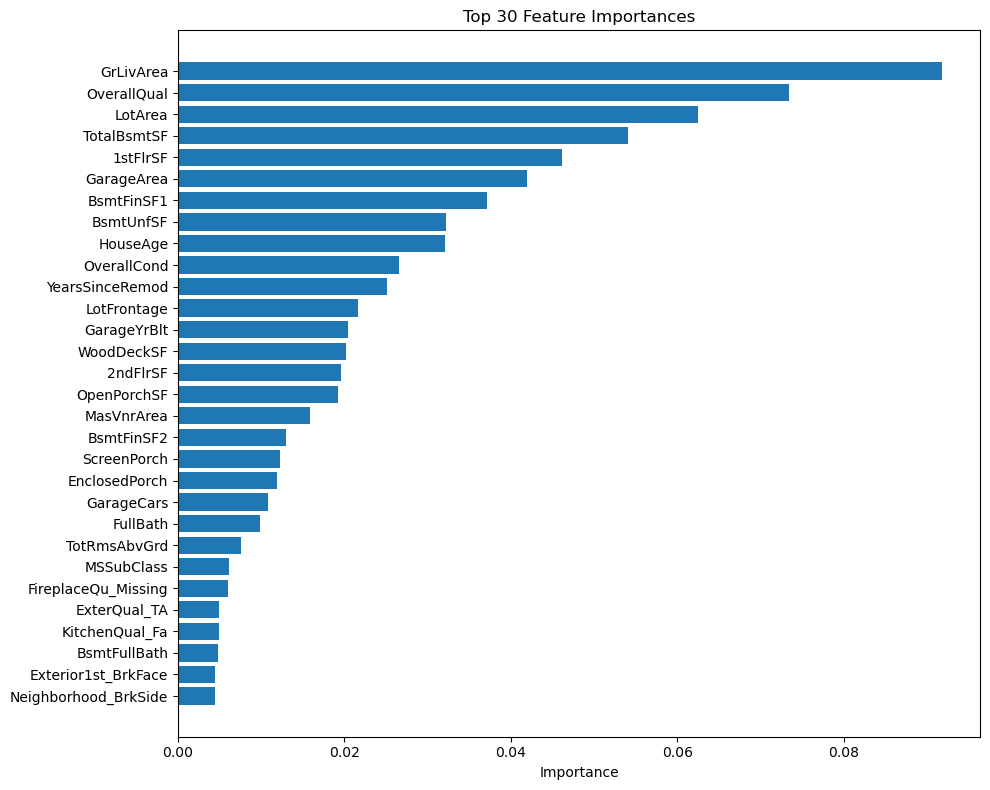

In [50]:
# Access the trained GradientBoostingRegressor from the pipeline
gbr_model = GBR_Pipeline.named_steps['model']

# Get feature importances
feature_importance = gbr_model.feature_importances_


# Get feature names after preprocessing
ohe = GBR_Pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)

# Numerical columns were passed through, so include their names
numerical_cols = [col for col in X.columns if col not in categorical_cols]
all_feature_names = np.concatenate([ohe_feature_names, numerical_cols])


importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)


import matplotlib.pyplot as plt

top_n = 30
top_features_df = importance_df.head(top_n)

plt.figure(figsize=(10, 8))
plt.barh(top_features_df['Feature'], top_features_df['Importance'])
plt.gca().invert_yaxis()
plt.title(f'Top {top_n} Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Test set

In [36]:
d_test = pd.read_csv('test.csv') 

## 2.1 convert types

In [37]:
d_test[['MSSubClass', 'MoSold', 'YearBuilt', 'YearRemodAdd', 'YrSold']] = d_test[['MSSubClass', 'MoSold', 'YearBuilt', 'YearRemodAdd', 'YrSold']].astype('object')

In [38]:
# Select only object or category columns
cat_cols = d_test.select_dtypes(include=["object", "category"]).columns

# Fill NaN values in only those columns
d_test[cat_cols] = d_test[cat_cols].fillna("Missing")

C:\Users\berra\AppData\Local\Temp\ipykernel_2104\2363930934.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  d_test[cat_cols] = d_test[cat_cols].fillna("Missing")


## 2.2 fill na 

In [39]:
# Imputation dans le test set (numeric)
d_test.fillna(0, inplace=True)

## 2.3 create variables

In [40]:
#'YearBuilt', 'YearRemodAdd, 'MoSold', 'YrSold' convert to quantitative
# List of columns to convert
columns_to_convert = ['YearBuilt', 'YearRemodAdd', 'MoSold', 'YrSold']

# Convert each to integer safely
for col in columns_to_convert:
    d_test.loc[:, col] = d_test[col].astype(int)

# Set reference year
reference_year = d_test['YrSold'].max()

# Create quantitative features safely
d_test.loc[:, 'HouseAge'] = reference_year - d_test['YearBuilt']
d_test.loc[:, 'YearsSinceRemod'] = reference_year - d_test['YearRemodAdd']


d_test = d_test.drop([
    'YearBuilt', 'YearRemodAdd', 'YrSold', 'MoSold'
], axis=1) 

# Convert object columns to numeric, forcing errors to NaN
cols_to_convert = ['HouseAge', 'YearsSinceRemod']
d_test[cols_to_convert] = d_test[cols_to_convert].apply(pd.to_numeric, errors='coerce')

## 2.4 cap outliers

In [41]:
num_features = [col for col in num_features if col != "SalePrice"]

for col in num_features:
    q_low, q_high = caps[col]
    d_test[col] = d_test[col].clip(lower=q_low, upper=q_high)


## 2.5 Predict

In [ ]:
# One-hot encode test set
X_test = d_test.drop(['Id'],axis=1)

y_pred = GBR_Pipeline.predict(X_test)

d_test['SalePrice'] = y_pred
d_test[['Id', 'SalePrice']].to_csv("predictions_GBR.csv", index=False)